In [ ]:
"""FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS"""

In [ ]:
###  Data Preparation and Exploration

            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


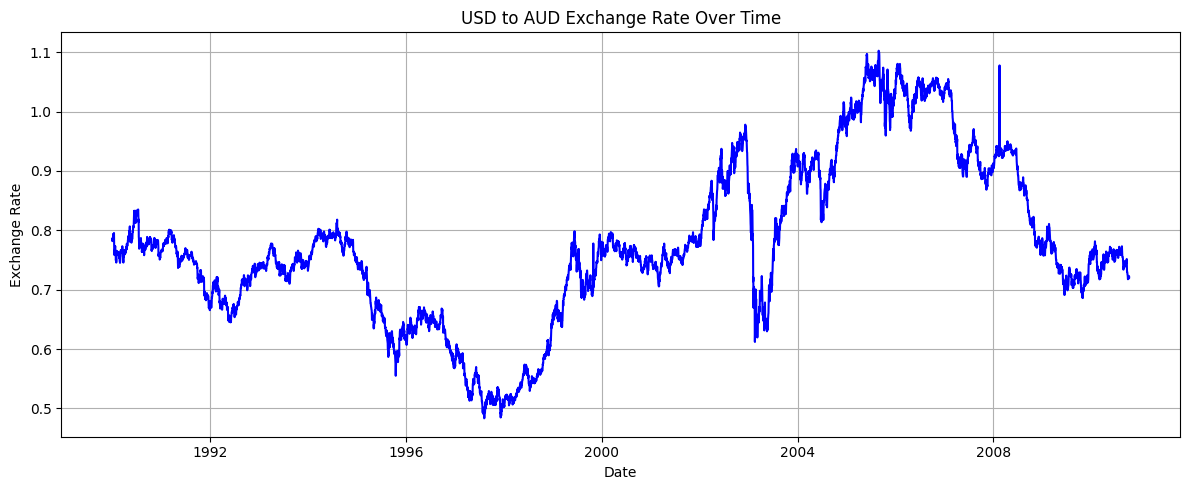

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("exchange_rate20.csv")

# Parse the date column and set it as index
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df.set_index('date', inplace=True)

# Display the first few rows
print(df.head())

# Plot the exchange rate time series
plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], color='blue')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""1. Trends:

1990–1997: Downward trend — USD was losing value against AUD, dropping from ~0.78 to ~0.50.

1997–2001: Recovery — USD gained strength, climbing back near 0.78.

2001–2004: Strong upward surge — USD rose sharply above 1.0.

2004–2008: Volatile but generally declining — slight recovery and then drop before the 2008 financial crisis.

2. Seasonality:

Currency markets don’t have strong yearly seasonality like sales data.

3. Anomalies / Spikes:

Around 2003–2004: Sharp drop and recovery.

Around 2004–2006: USD peaked above 1.10 — unusually high compared to the rest of the data.

Sudden small spikes (up or down) throughout, likely due to major economic announcements or market shocks."""

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving exchange_rate20.csv to exchange_rate20.csv


In [ ]:
# Check for missing values
print("Missing values:", df.isnull().sum())



Missing values:
 Ex_rate    0
dtype: int64


In [ ]:
### Model Building - ARIMA

/tmp/ipython-input-1113754883.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ex_rate'].interpolate(method='time', inplace=True)


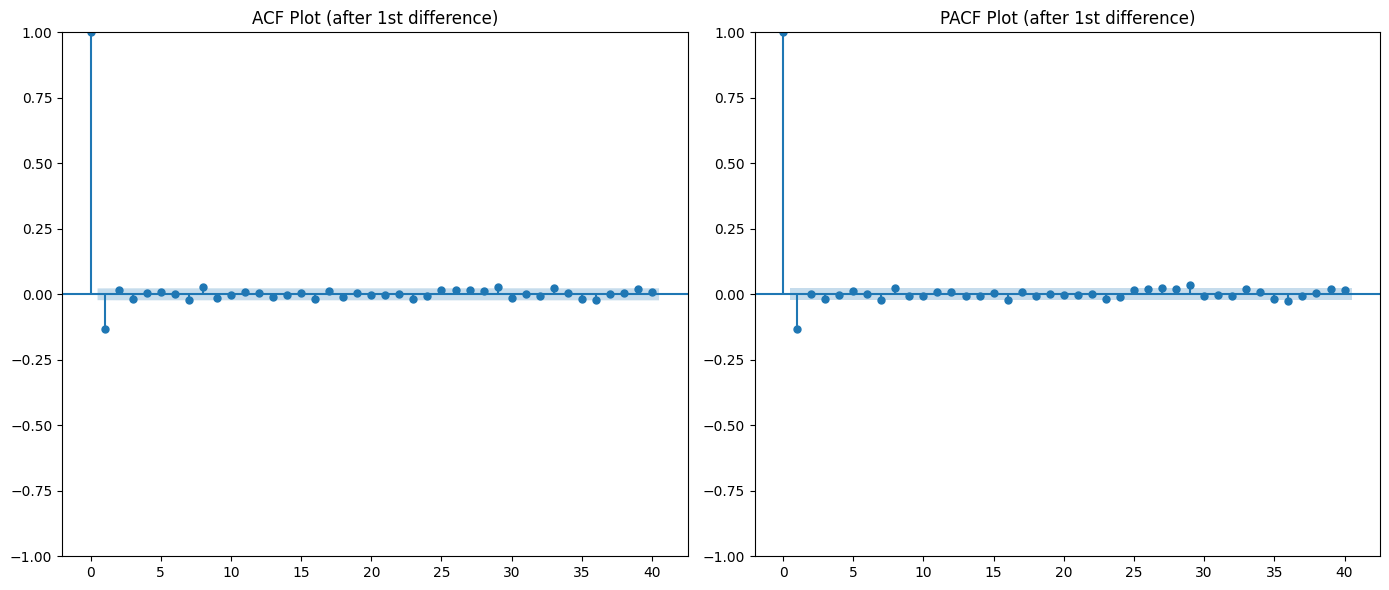

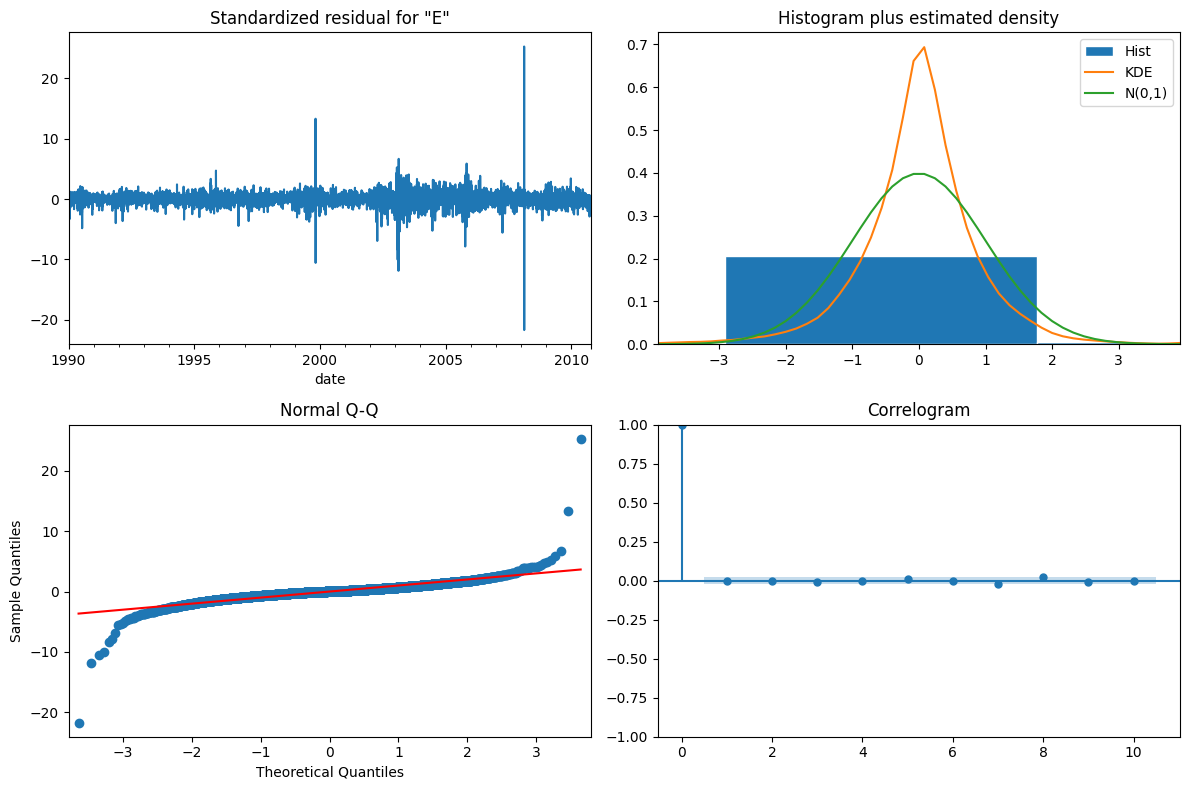

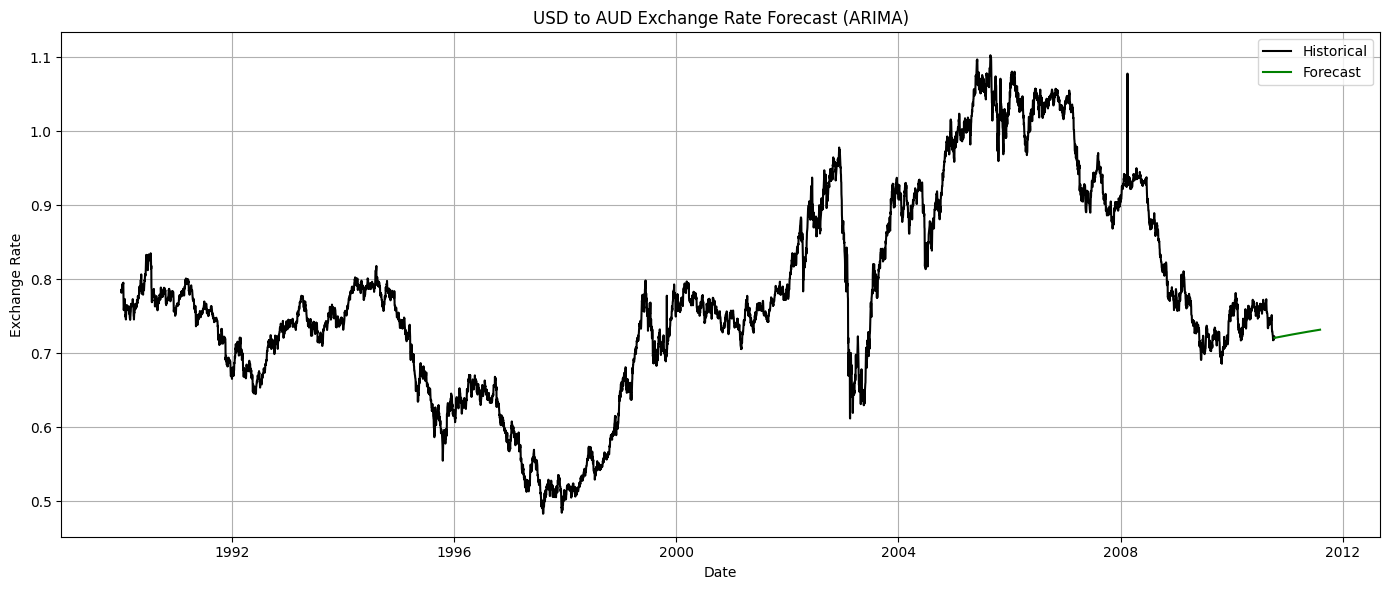

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Load preprocessed data
df = df.asfreq('D')  # Ensure daily frequency
df['Ex_rate'].interpolate(method='time', inplace=True)

# Step 1: ACF and PACF plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Ex_rate'].diff().dropna(), lags=40, ax=plt.gca())
plt.title('ACF Plot (after 1st difference)')

plt.subplot(1, 2, 2)
plot_pacf(df['Ex_rate'].diff().dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.title('PACF Plot (after 1st difference)')
plt.tight_layout()
plt.show()

# Based on plots, let's assume p=2, d=0, q=2
# Step 2: Fit ARIMA Model
arima_model = ARIMA(df['Ex_rate'], order=(2, 0, 2))
arima_result = arima_model.fit()

# Step 3: Diagnostics - residual analysis
arima_result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Step 4: Forecasting future values
forecast_steps = 300  # Predict next 300 days
forecast = arima_result.forecast(steps=forecast_steps)

# Create future date range for plotting
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot actual + forecast
plt.figure(figsize=(14, 6))
plt.plot(df['Ex_rate'], label='Historical', color='black')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title("USD to AUD Exchange Rate Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
forecast_series = pd.Series(forecast, index=forecast_index)
forecast_series

,predicted_mean
2010-10-11,0.720876
2010-10-12,0.720931
2010-10-13,0.720964
2010-10-14,0.721009
2010-10-15,0.721048
...,...
2011-08-02,0.731792
2011-08-03,0.731825
2011-08-04,0.731858
2011-08-05,0.731891


In [ ]:
### Model Building - Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fixed trend as 'add' due to up/downward direction
trend = 'add'
models = []
aic_values = []

# Try different seasonal settings only
for seasonal in ['add', 'mul']:
    try:
        model = ExponentialSmoothing(df['Ex_rate'],
                                     trend=trend,
                                     seasonal=seasonal,
                                     seasonal_periods=12)
        fit = model.fit()
        models.append((trend, seasonal, fit))
        aic_values.append(fit.aic)
    except Exception as e:
        print(f"Failed for seasonal={seasonal}: {e}")
        continue

# Select the best model based on lowest AIC
best_index = aic_values.index(min(aic_values))
best_trend, best_seasonal, best_model = models[best_index]
print(f"Best Model: Trend = {best_trend}, Seasonal = {best_seasonal}, AIC = {aic_values[best_index]}")


Best Model: Trend = add, Seasonal = mul, AIC = -77624.5507041401


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


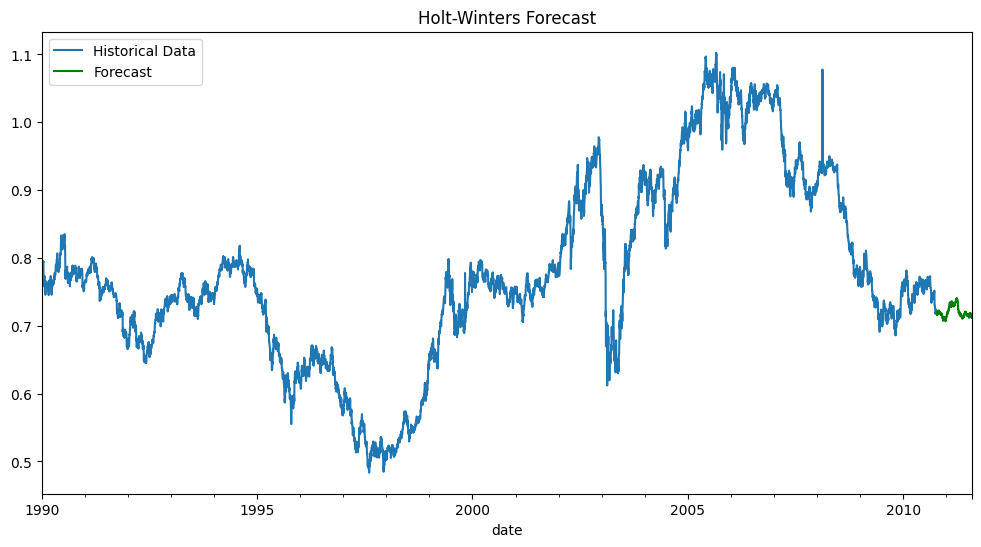

In [ ]:
# Refit the best model
final_model = ExponentialSmoothing(df['Ex_rate'],
                                   trend='add',
                                   seasonal='mul',
                                   seasonal_periods=365).fit()

# Forecast next 300 periods
forecast_steps = 300
forecast_values = final_model.forecast(steps=forecast_steps)

# Plot actual and forecasted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['Ex_rate'].plot(label='Historical Data')
forecast_values.plot(label='Forecast', color='green')
plt.legend()
plt.title('Holt-Winters Forecast')
plt.show()


In [ ]:
### Evaluation and Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming forecast_steps is already defined
# Get actual values from the original dataset
forecast_steps = 300
actual_values = df['Ex_rate'][-forecast_steps:]

# Forecast using ARIMA model
forecast_arima = arima_result.forecast(steps=forecast_steps)

# Forecast using Exponential Smoothing model
forecast_exp = best_model.forecast(steps=forecast_steps)

# Align the forecast indexes with actual values
forecast_arima.index = actual_values.index
forecast_exp.index = actual_values.index

# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Error Metrics for ARIMA
mae_arima = mean_absolute_error(actual_values, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_arima))
mape_arima = mean_absolute_percentage_error(actual_values, forecast_arima)

# Error Metrics for Exponential Smoothing
mae_exp = mean_absolute_error(actual_values, forecast_exp)
rmse_exp = np.sqrt(mean_squared_error(actual_values, forecast_exp))
mape_exp = mean_absolute_percentage_error(actual_values, forecast_exp)

# Print comparison
print("--- ARIMA Model Performance ---")
print(f"MAE:  {mae_arima:.6f}")
print(f"RMSE: {rmse_arima:.6f}")
print(f"MAPE: {mape_arima:.2f}%")

print("--- Exponential Smoothing Performance ---")
print(f"MAE:  {mae_exp:.6f}")
print(f"RMSE: {rmse_exp:.6f}")
print(f"MAPE: {mape_exp:.2f}%")



--- ARIMA Model Performance ---
MAE:  0.025752
RMSE: 0.028851
MAPE: 3.40%

--- Exponential Smoothing Performance ---
MAE:  0.031739
RMSE: 0.034876
MAPE: 4.19%


In [ ]:
""" Model Comparison
Performance:

From the evaluation metrics:

ARIMA showed lower errors with MAE = 0.025752, RMSE = 0.028851, and MAPE = 3.40%.

Exponential Smoothing had slightly higher errors: MAE = 0.031739, RMSE = 0.034876, and MAPE = 4.19%.

This clearly indicates that ARIMA is more accurate for this specific dataset.

Advantages:

ARIMA:

Captures autocorrelation and lagged patterns effectively.

Performs well with linear and stationary time series.

Can be tuned precisely using ACF/PACF plots.

Exponential Smoothing:

Simpler to implement and interpret.

Works well when strong trend or seasonality is present.

Suitable for shorter-term forecasting when seasonal effects are known.

Limitations:

ARIMA:

Requires stationarity (needs preprocessing like differencing).

Model selection (p,d,q) can be complex.



Exponential Smoothing:

May underperform when the data has complex autocorrelation.

Sensitive to seasonal_periods; incorrect values can reduce accuracy.

Over-smoothing can flatten forecasts.

Conclusion
Based on the observed error metrics and forecast accuracy, the ARIMA model provided better predictive performance for forecasting USD to AUD exchange rates in this dataset. Its ability to model autocorrelation and trend made it a better fit than Exponential Smoothing for this type of financial time series data.

Final Insight:
While both models are useful, ARIMA is recommended for this dataset due to its lower forecast error and better handling of the underlying time series dynamics. However, for datasets with strong seasonal patterns, Holt-Winters (Exponential Smoothing) might be more suitable.

